In [1]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from IPython.display import clear_output 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch import FloatTensor

import pickle

from bresenham import bresenham
from tqdm import tqdm_notebook, tqdm

In [2]:
data_path = '../output/coord_dict_large.p'
mask = np.load('../output/europe_mask.npy')
mask = np.roll(mask, -9, axis=0)

compass = {
    0: np.array([0, 1]), #E
    1: np.array([1, 0]), #N
    2: np.array([0, -1]), #W
    3: np.array([-1, 0]) #S
}

stationary_base = 0
translate_base = 1
rotate_base = 5

WAIT_REWARD = -1
ACTIVE_COLLECTING_REWARD = 2
PASSIVE_COLLECTING_REWARD = 5
TRANSLATE_REWARD = 0
ROTATE_REWARD = 0
HIT_WALL_REWARD = -10


INIT_SEED = 17
MAP_W = 350
MAP_H = 170

STEP_SIZE = 1

In [3]:
# Loading flow vector field, constant for the moment
uo = np.load('../output/uo.npy').T
vo = np.load('../output/vo.npy').T

In [4]:
def triangle_area(A, B, C):
    a = np.linalg.norm(B-C)
    b = np.linalg.norm(A-C)
    c = np.linalg.norm(A-B)
    
    # Calculate Semi-perimeter
    s = (a + b + c) / 2

    # calculate the area
    area = (s*(s-a)*(s-b)*(s-c)) ** 0.5
    
    return area

def is_in_triangle(P, A, B, C, eps=1e-6):
    area_ABC = triangle_area(A, B, C)
    
    area_ABP = triangle_area(A, B, P)
    area_ACP = triangle_area(A, C, P)
    area_BCP = triangle_area(B, C, P)
    
    return abs(area_ABC - (area_ABP + area_ACP + area_BCP)) < eps
    
def is_in_rectangle(P, A, B, C, D, eps=1e-6):
    return is_in_triangle(P, A, B, C, eps) or is_in_triangle(P, A, C, D, eps)


In [5]:
def is_crossing(A, B, C, D, eps=1e-6):
    if (max(A[0], B[0]) < min(C[0], D[0])):
        return False # There is no mutual abcisses
    
    if (max(A[1], B[1]) < min(C[1], D[1])):
        return False # There is no mutual ordonnees
    
    Ia = [max(min(A[0], B[0]), min(C[0],D[0])),
          min(max(A[0], B[0]), max(C[0], D[0]))]
    
    A1 = (A[1]-B[1])/(A[0]-B[0] + eps) # Pay attention to not dividing by zero
    A2 = (C[1]-D[1])/(C[0]-D[0] + eps) # Pay attention to not dividing by zero
    b1 = A[1]-A1*A[0]
    b2 = C[1]-A2*C[0]
    
    if (A1 == A2):
        return False # Parallel segments
    
    Xa = (b2 - b1) / (A1 - A2) # Once again, pay attention to not dividing by zero
    
    
    if Xa + eps < max(min(A[0], B[0]), min(C[0], D[0])) or Xa -eps > min(max(A[0], B[0]), max(C[0], D[0])):
        return False # intersection is out of bound
    else:
        return True

In [6]:
# crossing(np.array([0,0]), np.array([5,0]), np.array([5 + 1e-6, 1]), np.array([5+1e-6, -1]))

In [7]:
class FishingNet:
    
    def __init__(self, length, wall_matrix, seed=0):
        np.random.seed(seed)
        
        self.length = length
        self.num_rots = 10
        self.angle = np.random.randint(self.num_rots)
        self.rotations = range(self.num_rots)
        angle_step = np.pi/self.num_rots
        self.angles_list = np.array([(np.cos(angle_step * i), np.sin(angle_step * i)) for i in range(self.num_rots)])
        
        
        is_ok = False
        while not is_ok:
            #print(list_bresenham)
            self.pos_center = np.array([np.random.randint(MAP_W), np.random.randint(MAP_H)])
            list_bresenham = self.compute_bresenham()
            try:
                is_ok = not wall_matrix[list_bresenham[:,0], list_bresenham[:,1]].any()
            except IndexError: # If initialization out of bounds
                pass
        
    def translate(self, direction, wall_matrix):
        reward = 0
        old_pos = self.pos_center
        self.pos_center = self.pos_center + STEP_SIZE*compass[direction]
        list_bresenham = self.compute_bresenham()
        if wall_matrix[list_bresenham[:,0], list_bresenham[:,1]].any():
            reward += HIT_WALL_REWARD
            self.pos_center = old_pos
        else:
            reward += TRANSLATE_REWARD
            
        return reward
    
    def rotate(self, rotation, wall_matrix):
        reward = 0
        old_rot = self.angle
        
        self.angle = self.angle + rotation
        if self.angle == self.num_rots:
            self.angle = 0
        elif self.angle == -1:
            self.angle = self.num_rots -1
        
        list_bresenham = self.compute_bresenham()
        if wall_matrix[list_bresenham[:,0], list_bresenham[:,1]].any():
            reward += HIT_WALL_REWARD
            self.angle = old_rot
        else:
            reward += ROTATE_REWARD 
            
        return reward
    
    def end_points(self):
        return (self.pos_center + self.length/2 * self.angles_list[self.angle], self.pos_center - self.length/2 * self.angles_list[self.angle])
    
    def compute_bresenham(self):
        endpoints = self.end_points()
        return np.array(list(bresenham(int(endpoints[0][0]), int(endpoints[0][1]), int(endpoints[1][0]), int(endpoints[1][1])))).astype(np.int)

In [8]:
class Environment:
    
    def __init__(self, data_path, mask, fishnet_length, n_fishing_nets=1):
        self.mask = mask.T
        self.n_fishing_nets = n_fishing_nets
        self.fishnet_length = fishnet_length
        self.data_path = data_path
    
    def reset(self):
        self.t = 0
        with open(self.data_path, 'rb') as f:
            self.data = pickle.load(f)
        self.particles = self.data[self.t] 
        self.flows = self.data[self.t]
        self.fishing_nets = [FishingNet(self.fishnet_length, self.mask, seed=i+INIT_SEED) for i in range(self.n_fishing_nets)]
        self.fishnet_pos_history = []
        
    
    def step(self, actions):
        total_reward = 0
        rewards = np.zeros(self.n_fishing_nets)
        for i, fnet in enumerate(self.fishing_nets):
            rewards[i] += self.update_fishing_net(fnet, actions[i])
            
        rewards += self.update_particles()
        self.t += 1
        self.fishnet_pos_history.append(self.fishing_nets[0].end_points())
        return rewards
    
    def remove_particle(self, caught_particles):
        for particle_id in caught_particles:
            for future_step in range(self.t+1, len(self.data)):
                del self.data[future_step][particle_id]
            del self.particles[particle_id]
    
    def update_fishing_net(self, fnet, action):
        """Update fishing nets positions and gather reward on particles caught by the movements"""
        reward = 0
        caught_particles = []
        if action < translate_base: # No movement
            
            return WAIT_REWARD
        elif action < rotate_base: # Translation
            old_end_points = fnet.end_points()
            reward += fnet.translate(action - translate_base, self.mask) # Hit Wall penalty
            new_end_points = fnet.end_points()
            for k, particle in self.particles.items():
                if is_in_rectangle(np.array(particle)/10, old_end_points[0], old_end_points[1], new_end_points[0], new_end_points[1]):
                    caught_particles.append(k)
                    reward += ACTIVE_COLLECTING_REWARD
                else: 
                    reward += 0
            self.remove_particle(caught_particles)
            
            return reward + TRANSLATE_REWARD
        else: # Rotation
            old_end_points = fnet.end_points()
            reward += fnet.rotate(2*(action - rotate_base)-1, self.mask) # Hit Wall penalty
            new_end_points = fnet.end_points()
            for k, particle in self.particles.items():
                if is_in_triangle(np.array(particle)/10, fnet.pos_center, old_end_points[0], new_end_points[0])\
                or is_in_triangle(particle, fnet.pos_center, old_end_points[1], new_end_points[1]):    
                    caught_particles.append(k)
                    reward += ACTIVE_COLLECTING_REWARD  
                else:
                    reward += 0
            self.remove_particle(caught_particles)
        
            return reward + ROTATE_REWARD
    
    def update_particles(self):
        """Update particles positions and gather rewards on particles crossing nets"""
        rewards = np.zeros(self.n_fishing_nets)
        new_particles = self.data[self.t+1]

        for i, fnet in enumerate(self.fishing_nets):
            #Update particle position and check if it touches a Net
            
            segment = fnet.end_points()
            #rewards = PASSIVE_COLLECTING_REWARD if is_crossing(diffs[:,0], diffs[:,1], segment[0], segment[1]) # Will be faster if we get it to work
            caught_particles = []
            for k, v in self.particles.items():
                #print(v, new_particles[k], segment[0], segment[1])
                if is_crossing(np.array(v)/10, np.array(new_particles[k])/10, segment[0], segment[1]):
                    caught_particles.append(k)
                    rewards[i] += PASSIVE_COLLECTING_REWARD 
                else:
                    rewards[i] += 0
            self.remove_particle(caught_particles)

        self.particles = self.data[self.t+1]
        return rewards
    
    def get_state(self):
        particles_state = np.zeros((MAP_W, MAP_H))
        for k, v in self.data[self.t].items():
            particles_state[int(v[0]/10), int(v[1]/10)] += 1 
        fnet_coords = self.fishing_nets[0].compute_bresenham() # Assume we have only one fishnet
        fnet_state = np.zeros((MAP_W, MAP_H))
        for p in fnet_coords:
            fnet_state[p[0], p[1]] += 1
        return FloatTensor([[particles_state, self.mask, fnet_state, uo, vo]]).cuda()
        
    def close(self):
        raise NotImplementedError

In [9]:
# with open(data_path, 'rb') as f:
#     data = pickle.load(f)

In [10]:
# len(data[0].keys())
# mat = np.zeros((MAP_W, MAP_H))
# for k, v in data[0].items():
#     mat[int(v[0]/10), int(v[1]/10)] += 1

In [11]:
# from matplotlib import animation, rc
# from IPython.display import HTML

# fig, ax = plt.subplots(1, 1, figsize=[10, 10])
# def init(fig, ax):
#     mat = np.zeros((MAP_W, MAP_H))
#     for k, v in data[0].items():
#         mat[int(v[0]/10), int(v[1]/10)] += 1
#     ax.spy(mat.T != 0)

# def simulate(i):
#     mat = np.zeros((MAP_W, MAP_H))
#     for k, v in data[i].items():
#         mat[int(v[0]/10), int(v[1]/10)] += 1
#     print((mat != 0).sum())
#     ax.spy(mat.T != 0)
#     return (ax,)

# anim = animation.FuncAnimation(fig, simulate, init_func=init(fig,ax),
#                                frames=50, interval=200, 
#                                blit=False)


# HTML(anim.to_jshtml())

In [12]:
# flow_path 
env = Environment(data_path= data_path, mask=mask, fishnet_length = 10)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [14]:
class DQN(nn.Module):

    def __init__(self, h, w):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(5, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, 7) # 448 or 512

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

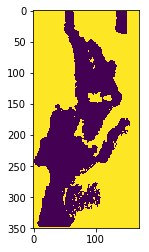

In [15]:
plt.imshow(255*env.mask)

In [16]:
# resize = T.Compose([T.ToPILImage(),
#                     T.Resize(40, interpolation=Image.CUBIC),
#                     T.ToTensor()])


env.reset()
# plt.figure()

# plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
#            interpolation='none')
# plt.title('Example extracted screen')
# plt.show()

In [17]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = env.get_state()

policy_net = DQN(MAP_W, MAP_H).to(device)
target_net = DQN(MAP_W, MAP_H).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(7)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [18]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [19]:
num_episodes = 10
for i_episode in tqdm_notebook(range(num_episodes)):
    # Initialize the environment and state
    env.reset()
    last_state = env.get_state()
    current_state = env.get_state()
#     state = current_state - last_state
    for t in range(359):
        
        # Select and perform an action
        action = select_action(current_state)
        reward = env.step([action.item()])[0]
        reward = torch.tensor([reward], device=device)
#         print(f'{t}: Reward {reward.item()}')
        print(f'{t}: Reward {reward.item()}', end="\r")
#         print(env.fishing_nets[0].end_points())

        # Observe new state
        last_state = current_state
        current_state = env.get_state()
#         if not done:
#             next_state = current_screen - last_screen
#         else:
#             next_state = None

        # Store the transition in memory
        memory.push(current_state, action, current_state, reward)

        # Move to the next state
#         state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
#         if done:
#             episode_durations.append(t + 1)
#             plot_durations()
#             break
    # Update the target network, copying all weights and biases in DQN
#     os.mkdir(f'results/episode_{i_episode}')
    with open(f'results/particles_pos_episode_{i_episode}.pkl', 'wb') as f:
        pickle.dump(env.data, f)
        
    with open(f'results/fishnet_pos_episode_{i_episode}.pkl', 'wb') as f:
        pickle.dump(env.fishnet_pos_history, f)
        
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    

print('Complete')

KeyboardInterrupt: 